In [1]:
# %% [markdown]
# ## 1. Imports and Setup

# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance

# prediction handles (may be set later)
predict_fn = None
model_obj = None

# Try xgboost / lightgbm if installed
MODEL_BACKENDS = {}
try:
    import xgboost as xgb
    MODEL_BACKENDS['xgb'] = True
except Exception:
    MODEL_BACKENDS['xgb'] = False
try:
    import lightgbm as lgb
    MODEL_BACKENDS['lgb'] = True
except Exception:
    MODEL_BACKENDS['lgb'] = False

print('Model backends available:', MODEL_BACKENDS)

Model backends available: {'xgb': True, 'lgb': True}


In [2]:
# %% [markdown]
# ## 2. Paths and Helper Utilities

# Use local data directory structure: data/train contains train CSVs; data/ has test and sample_submission
DATA_DIR = os.path.join(os.getcwd(), 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
RESULTS = os.path.join(DATA_DIR, 'results')
os.makedirs(RESULTS, exist_ok=True)

expected_train_files = [
    'new_house_transactions.csv',
    'new_house_transactions_nearby_sectors.csv',
    'pre_owned_house_transactions.csv',
    'pre_owned_house_transactions_nearby_sectors.csv',
    'land_transactions.csv',
    'land_transactions_nearby_sectors.csv',
    'sector_POI.csv',
    'city_search_index.csv',
    'city_indexes.csv'
]
expected_data_files = ['test.csv', 'sample_submission.csv']

present_train = [f for f in expected_train_files if os.path.exists(os.path.join(TRAIN_DIR, f))]
missing_train = [f for f in expected_train_files if f not in present_train]
present_data = [f for f in expected_data_files if os.path.exists(os.path.join(DATA_DIR, f))]
missing_data = [f for f in expected_data_files if f not in present_data]
print('Found train files:', present_train)
print('Found data files:', present_data)
if missing_train:
    print('\nWarning - missing train files:', missing_train)
if missing_data:
    print('\nWarning - missing data files:', missing_data)

# Helper functions

def safe_read_train(fn):
    """Read CSV from train directory with BOM handling"""
    p = os.path.join(TRAIN_DIR, fn)
    if os.path.exists(p):
        return pd.read_csv(p, encoding='utf-8-sig')
    return None

def safe_read_data(fn):
    """Read CSV from data directory with BOM handling"""
    p = os.path.join(DATA_DIR, fn)
    if os.path.exists(p):
        return pd.read_csv(p, encoding='utf-8-sig')
    return None

def normalize_month_col(df: pd.DataFrame, col: str = 'month') -> pd.DataFrame:
    """Normalize all month values to consistent 'YYYY-Mon' format for joins"""
    if df is None or col not in df.columns:
        return df
    m = pd.to_datetime(df[col], errors='coerce')
    if isinstance(m, pd.Series):
        df[col] = m.dt.strftime('%Y-%b')
    return df

Found train files: ['new_house_transactions.csv', 'new_house_transactions_nearby_sectors.csv', 'pre_owned_house_transactions.csv', 'pre_owned_house_transactions_nearby_sectors.csv', 'land_transactions.csv', 'land_transactions_nearby_sectors.csv', 'sector_POI.csv', 'city_search_index.csv', 'city_indexes.csv']
Found data files: ['test.csv', 'sample_submission.csv']


In [3]:
# %% [markdown]
# ## 3. Load Datasets

# %%
new_house = normalize_month_col(safe_read_train('new_house_transactions.csv'))
new_house_nearby = normalize_month_col(safe_read_train('new_house_transactions_nearby_sectors.csv'))
pre_owned = normalize_month_col(safe_read_train('pre_owned_house_transactions.csv'))
pre_owned_nearby = normalize_month_col(safe_read_train('pre_owned_house_transactions_nearby_sectors.csv'))
land = normalize_month_col(safe_read_train('land_transactions.csv'))
land_nearby = normalize_month_col(safe_read_train('land_transactions_nearby_sectors.csv'))
sector_poi = safe_read_train('sector_POI.csv')
city_search = normalize_month_col(safe_read_train('city_search_index.csv'))
city_index = safe_read_train('city_indexes.csv')
test = safe_read_data('test.csv')
sample_sub = safe_read_data('sample_submission.csv')

# Quick shape report
for name, df in [('new_house', new_house), ('pre_owned', pre_owned), ('land', land),
                 ('sector_poi', sector_poi), ('city_search', city_search), ('city_index', city_index)]:
    if df is None:
        print(f"{name}: MISSING")
    else:
        print(f"{name}: {df.shape}")

new_house: (5433, 11)
pre_owned: (5360, 6)
land: (5896, 6)
sector_poi: (86, 142)
city_search: (4020, 4)
city_index: (7, 74)


In [4]:
# %% [markdown]
# ## 4. Initial Cleaning
# - For transaction tables, missing numeric values typically mean zero transactions: fill with 0
# - For POI, drop features with >70% missing to avoid sparse noise
# - Aggregate city_search by month

# %%
# Clean transaction tables
transaction_tables = {
    'new_house': new_house,
    'new_house_nearby': new_house_nearby,
    'pre_owned': pre_owned,
    'pre_owned_nearby': pre_owned_nearby,
    'land': land,
    'land_nearby': land_nearby
}
for k, df in transaction_tables.items():
    if df is not None:
        # numeric fillna
        numcols = df.select_dtypes(include=[np.number]).columns.tolist()
        df[numcols] = df[numcols].fillna(0)
        # strip whitespace in string cols
        for c in df.select_dtypes(include=['object']).columns:
            df[c] = df[c].astype(str).str.strip()

print('Transaction tables cleaned')

# %%
# POI cleaning
poi_clean = None
if sector_poi is not None:
    missing_ratio = sector_poi.isna().mean()
    drop_cols = missing_ratio[missing_ratio > 0.7].index.tolist()
    print('Dropping POI columns with >70% missing:', len(drop_cols))
    poi_clean = sector_poi.drop(columns=drop_cols).copy()
    poi_clean.fillna(0, inplace=True)
    print('POI cleaned')

# %%
# City search aggregate
city_search_agg = None
if city_search is not None:
    # find a numeric column to sum
    if 'search_volume' in city_search.columns:
        city_search_agg = (
            city_search.groupby('month', as_index=False)
                       .agg({'search_volume':'sum'})
                       .rename(columns={'search_volume':'city_search_volume'})
        )
    else:
        # try heuristics
        cand = [c for c in city_search.columns if 'search' in c.lower() or 'volume' in c.lower()]
        if cand:
            key = cand[0]
            city_search_agg = (
                city_search.groupby('month', as_index=False)
                           .agg({key:'sum'})
                           .rename(columns={key:'city_search_volume'})
            )
    print('City search aggregated')

# %%
# City index cleaning
if city_index is not None:
    # drop columns with >80% missing in city_index
    miss_idx = city_index.isna().mean()
    drop_idx = miss_idx[miss_idx>0.8].index.tolist()
    city_index_clean = city_index.drop(columns=drop_idx).copy()
    # forward/backward fill for plausible continuity
    city_index_clean = city_index_clean.sort_values('city_indicator_data_year').ffill().bfill()
    print('City index cleaned')
else:
    city_index_clean = None

print('\nAll cleaning complete')

Transaction tables cleaned
Dropping POI columns with >70% missing: 0
POI cleaned
City search aggregated
City index cleaned

All cleaning complete


In [5]:
# %% [markdown]
# ## 5. Aggregate Transaction Tables by Month + Sector

# %%
from typing import Optional

def agg_numeric_month_sector(df: Optional[pd.DataFrame]):
    """Aggregate numeric columns by month and sector"""
    if df is None:
        return None
    if 'month' not in df.columns or 'sector' not in df.columns:
        return None
    numcols = df.select_dtypes(include=[np.number]).columns.tolist()
    return df.groupby(['month','sector'])[numcols].sum().reset_index()

agg_new = agg_numeric_month_sector(new_house)
agg_pre = agg_numeric_month_sector(pre_owned)
agg_land = agg_numeric_month_sector(land)
agg_new_near = agg_numeric_month_sector(new_house_nearby)
agg_pre_near = agg_numeric_month_sector(pre_owned_nearby)
agg_land_near = agg_numeric_month_sector(land_nearby)

print('Aggregated shapes:', [d.shape if d is not None else None for d in [agg_new, agg_pre, agg_land]])

Aggregated shapes: [(5433, 11), (5360, 6), (5896, 6)]


In [12]:
# %% [markdown]
# ## 6. Merge All Tables into Single Modeling Dataset

# %%
merged = None
if agg_new is not None:
    merged = agg_new.copy()

    def merge_with_prefix(base, other, prefix):
        """Merge with column prefix"""
        if other is None:
            return base
        o = other.copy()
        for c in o.columns:
            if c not in ['month','sector']:
                o.rename(columns={c: f"{prefix}_{c}"}, inplace=True)
        return base.merge(o, on=['month','sector'], how='left')

    merged = merge_with_prefix(merged, agg_pre, 'pre')
    merged = merge_with_prefix(merged, agg_land, 'land')
    merged = merge_with_prefix(merged, agg_new_near, 'new_near')
    merged = merge_with_prefix(merged, agg_pre_near, 'pre_near')
    merged = merge_with_prefix(merged, agg_land_near, 'land_near')
    print('Merged transaction tables')

# %%
# Merge city search
if merged is not None and city_search_agg is not None:
    merged = merged.merge(city_search_agg, on='month', how='left')
    print('Merged city search')

# %%
# Merge POI
if merged is not None and poi_clean is not None:
    # ensure consistent types (cast both to string for safety)
    merged['sector'] = merged['sector'].astype(str)
    poi_tmp = poi_clean.copy()
    poi_tmp['sector'] = poi_tmp['sector'].astype(str)
    merged = merged.merge(poi_tmp, on='sector', how='left')
    print('Merged POI')

# %%
# Merge city index by year
if merged is not None and city_index_clean is not None:
    # extract year using datetime parsing for robustness
    def month_to_year(m):
        try:
            return pd.to_datetime(m, errors='coerce').year
        except Exception:
            try:
                return int(str(m)[:4])
            except:
                return np.nan
    merged['year'] = merged['month'].apply(month_to_year)

    if 'city_indicator_data_year' in city_index_clean.columns:
        ci = city_index_clean.copy()
        ci = ci.rename(columns={'city_indicator_data_year':'year'})
        numeric_ci = ['year'] + [c for c in ci.select_dtypes(include=[np.number]).columns if c!='year']
        ci = ci[numeric_ci]
        # prefix
        ci = ci.rename(columns={c: f"cityidx_{c}" for c in ci.columns if c!='year'})
        merged = merged.merge(ci, on='year', how='left')
        print('Merged city index')

# %%
# Final numeric fill
if merged is not None:
    numcols = merged.select_dtypes(include=[np.number]).columns.tolist()
    merged[numcols] = merged[numcols].fillna(0)
    print('\nMerged dataset shape:', merged.shape)
    display(merged.head())

# %%
# Save merged dataset
if merged is not None:
    merged.to_csv(os.path.join(RESULTS, 'merged_full.csv'), index=False)
    print('Saved merged_full.csv')

Merged transaction tables
Merged city search
Merged POI
Merged city index

Merged dataset shape: (6419, 251)


,month,sector,num_new_house_transactions,area_new_house_transactions,price_new_house_transactions,amount_new_house_transactions,area_per_unit_new_house_transactions,total_price_per_unit_new_house_transactions,num_new_house_available_for_sale,area_new_house_available_for_sale,...,cityidx_internet_broadband_access_subscribers_10k,cityidx_internet_broadband_access_ratio,cityidx_number_of_industrial_enterprises_above_designated_size,cityidx_total_current_assets_10k,cityidx_total_fixed_assets_10k,cityidx_main_business_taxes_and_surcharges_10k,cityidx_real_estate_development_investment_completed_10k,cityidx_residential_development_investment_completed_10k,cityidx_science_expenditure_10k,cityidx_education_expenditure_10k
0,2019-Apr,sector 1,69,6935,38392,26626.68,101,385.89,141.0,12936.0,...,565.83,0.593287,5804.0,110643480.0,39934058.0,4862051.0,31022573.0,20870742.0,2439456.0,5239743.0
1,2019-Apr,sector 10,12,1181,28686,3387.26,98,282.27,123.0,11736.0,...,565.83,0.593287,5804.0,110643480.0,39934058.0,4862051.0,31022573.0,20870742.0,2439456.0,5239743.0
2,2019-Apr,sector 11,28,3282,11596,3805.46,117,135.91,621.0,121036.0,...,565.83,0.593287,5804.0,110643480.0,39934058.0,4862051.0,31022573.0,20870742.0,2439456.0,5239743.0
3,2019-Apr,sector 12,25,2822,20674,5833.06,113,233.32,239.0,29774.0,...,565.83,0.593287,5804.0,110643480.0,39934058.0,4862051.0,31022573.0,20870742.0,2439456.0,5239743.0
4,2019-Apr,sector 13,87,8601,40474,34810.78,99,400.12,703.0,74686.0,...,565.83,0.593287,5804.0,110643480.0,39934058.0,4862051.0,31022573.0,20870742.0,2439456.0,5239743.0


Saved merged_full.csv



Target basic stats:
count      6419.000000
mean      32136.788271
std       47944.285183
min          50.950000
25%        5302.300000
50%       16393.770000
75%       38126.600000
max      606407.640000
Name: amount_new_house_transactions, dtype: float64

Top correlated features:
amount_new_house_transactions                 1.000000
area_new_house_transactions                   0.862835
num_new_house_transactions                    0.835402
area_new_house_available_for_sale             0.478662
num_new_house_available_for_sale              0.471070
pre_area_pre_owned_house_transactions         0.402155
pre_num_pre_owned_house_transactions          0.397498
number_of_residential_commercial              0.351807
number_of_hypermarkets                        0.341444
number_of_unranked_malls                      0.315932
number_of_shopping_centers                    0.311541
number_of_leisure_and_entertainment_stores    0.310689
pre_amount_pre_owned_house_transactions       0.307610
nu

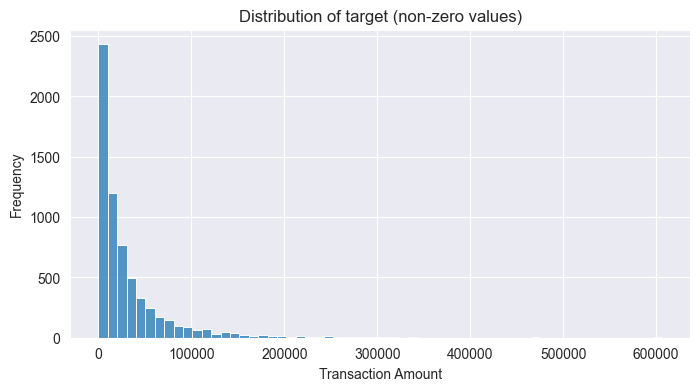

In [13]:
# %% [markdown]
# ## 7. Exploratory Data Analysis (EDA)

# %%
if merged is not None:
    # infer target column name
    if 'amount_new_house_transactions' not in merged.columns:
        cand = [c for c in merged.columns if 'amount' in c and 'new' in c]
        if cand:
            merged['amount_new_house_transactions'] = merged[cand[0]]
        elif 'num_new_house_transactions' in merged.columns and 'price_new_house_transactions' in merged.columns:
            merged['amount_new_house_transactions'] = merged['num_new_house_transactions'] * merged['price_new_house_transactions']
        else:
            # create zero target — model won't be meaningful
            merged['amount_new_house_transactions'] = 0

    target = 'amount_new_house_transactions'
    print('\nTarget basic stats:')
    print(merged[target].describe())

    # top positive correlation features (numeric columns only)
    num_cols = merged.select_dtypes(include=[np.number]).columns
    corr = merged[num_cols].corrwith(merged[target]).abs().sort_values(ascending=False)
    print('\nTop correlated features:')
    print(corr.head(20))

# %%
# Plot target distribution
if merged is not None:
    target = 'amount_new_house_transactions'
    plt.figure(figsize=(8,4))
    sns.histplot(merged[target].replace(0, np.nan).dropna(), bins=60)
    plt.title('Distribution of target (non-zero values)')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
# %% [markdown]
# ## 8. Feature Engineering
# - Time features (month number, season)
# - Lag features (1-month and 3-month lags)
# - Rolling mean features
# - Supply-demand ratio
# - Log transforms for heavy-tailed distributions

# %%
if merged is not None:
    # derive datetime for month and calendar features
    merged['month_dt'] = pd.to_datetime(merged['month'], errors='coerce')
    merged['month_num'] = merged['month_dt'].dt.month.fillna(0).astype(int)
    merged['season'] = ((merged['month_num']%12)//3)+1
    print('Created time features')

# %%
# Sort for lagging using chronological order
if merged is not None:
    merged = merged.sort_values(['sector','month_dt']).reset_index(drop=True)
    print('Sorted by sector and time')

# %%
# Create lag features
if merged is not None:
    lag_cols = []
    for col in ['num_new_house_transactions','area_new_house_transactions',
                'price_new_house_transactions','amount_new_house_transactions']:
        if col in merged.columns:
            for lag in [1,3]:
                newcol = f"{col}_lag{lag}"
                merged[newcol] = merged.groupby('sector')[col].shift(lag).fillna(0)
                lag_cols.append(newcol)
    print(f'Created {len(lag_cols)} lag features')

# %%
# Create rolling mean features
if merged is not None and 'num_new_house_transactions' in merged.columns:
    merged['num_new_house_transactions_roll3'] = (
        merged.groupby('sector')['num_new_house_transactions']
              .rolling(window=3, min_periods=1).mean()
              .reset_index(level=0, drop=True)
    )
    print('Created rolling mean features')

# %%
# Supply-demand ratio
if merged is not None:
    if 'num_new_house_available_for_sale' in merged.columns and 'num_new_house_transactions' in merged.columns:
        merged['supply_demand_ratio'] = merged['num_new_house_available_for_sale'] / (merged['num_new_house_transactions'].replace(0, np.nan))
        merged['supply_demand_ratio'] = merged['supply_demand_ratio'].replace(np.inf, 0).fillna(0)
        print('Created supply-demand ratio')

# %%
# Log transforms for heavy tail columns
if merged is not None:
    heavy = [c for c in merged.select_dtypes(include=[np.number]).columns
             if 'amount' in c or 'transaction' in c or 'price' in c]
    for c in heavy:
        newc = c + '_log1p'
        merged[newc] = np.log1p(merged[c].clip(lower=0))
    print(f'Created {len(heavy)} log-transformed features')

# %%
# Save engineered dataset
if merged is not None:
    merged.to_csv(os.path.join(RESULTS, 'merged_engineered.csv'), index=False)
    print('Saved merged_engineered.csv')

Created time features
Sorted by sector and time
Created 8 lag features
Created rolling mean features
Created supply-demand ratio
Created 35 log-transformed features
Saved merged_engineered.csv


In [15]:
# %% [markdown]
# ## 9. Feature Selection
# - Pearson correlation (absolute) with target
# - Mutual information (nonlinear)
# - RandomForest feature importance + permutation importance

# %%
if merged is not None:
    # Prepare X, y
    target = 'amount_new_house_transactions'
    drop_cols = ['month','month_dt','sector','year', target] if 'year' in merged.columns else ['month','month_dt','sector', target]
    features = [c for c in merged.columns if c not in drop_cols]
    X = merged[features].copy()
    y = merged[target].copy()

    # encode object cols
    obj_cols = X.select_dtypes(include=['object']).columns.tolist()
    for c in obj_cols:
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))

    print(f'Feature matrix shape: {X.shape}')
    print(f'Target shape: {y.shape}')

# %%
# Check if target is valid
if merged is not None:
    if y.nunique() <= 1 and list(y.unique())[0]==0:
        print('\nWARNING: Target is constant; cannot compute importances. Check dataset.')
    else:
        print('Target has variance - proceeding with feature selection')

# %%
# Correlation-based feature selection
if merged is not None and not (y.nunique() <= 1 and list(y.unique())[0]==0):
    corr_abs = X.corrwith(y).abs().sort_values(ascending=False)
    corr_df = corr_abs.reset_index().rename(columns={'index':'feature',0:'abs_corr'})
    corr_df = corr_df[~corr_df['feature'].isin(obj_cols)]
    print('Computed correlation-based importance')

# %%
# Mutual information
if merged is not None and not (y.nunique() <= 1 and list(y.unique())[0]==0):
    sample_frac = 1.0 if X.shape[0] < 10000 else 0.4
    X_mi = X.sample(frac=sample_frac, random_state=42) if sample_frac < 1 else X
    y_mi = y.loc[X_mi.index]
    mi = mutual_info_regression(X_mi, y_mi, random_state=42)
    mi_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mi}).sort_values('mutual_info', ascending=False)
    print('Computed mutual information')

# %%
# RandomForest importance
if merged is not None and not (y.nunique() <= 1 and list(y.unique())[0]==0):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    imp_df = pd.DataFrame({'feature': X.columns, 'rf_importance': rf.feature_importances_}).sort_values('rf_importance', ascending=False)
    print('Computed RandomForest importance')

# %%
# Permutation importance
if merged is not None and not (y.nunique() <= 1 and list(y.unique())[0]==0):
    perm = permutation_importance(rf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    perm_df = pd.DataFrame({
        'feature': X.columns,
        'perm_mean': perm.importances_mean,
        'perm_std': perm.importances_std
    }).sort_values('perm_mean', ascending=False)
    print('Computed permutation importance')

# %%
# Combine all importance metrics
if merged is not None and not (y.nunique() <= 1 and list(y.unique())[0]==0):
    comb = imp_df.merge(mi_df, on='feature').merge(perm_df[['feature','perm_mean']], on='feature')
    comb['r_rf'] = comb['rf_importance'].rank(ascending=False, method='min')
    comb['r_mi'] = comb['mutual_info'].rank(ascending=False, method='min')
    comb['r_perm'] = comb['perm_mean'].rank(ascending=False, method='min')
    comb['rank_mean'] = comb[['r_rf','r_mi','r_perm']].mean(axis=1)
    comb = comb.sort_values('rank_mean').reset_index(drop=True)

    # Save results
    comb.to_csv(os.path.join(RESULTS, 'feature_ranking_combined.csv'), index=False)
    imp_df.to_csv(os.path.join(RESULTS, 'rf_importances.csv'), index=False)
    mi_df.to_csv(os.path.join(RESULTS, 'mutual_info.csv'), index=False)
    perm_df.to_csv(os.path.join(RESULTS, 'permutation_importances.csv'), index=False)
    print('Saved feature importance outputs to', RESULTS)

    # show top 25
    print('\nTop 25 features by combined ranking:')
    display(comb.head(25))

Feature matrix shape: (6419, 294)
Target shape: (6419,)
Target has variance - proceeding with feature selection
Computed correlation-based importance
Computed mutual information
Computed RandomForest importance
Computed permutation importance
Saved feature importance outputs to C:\Users\Mitudru\Documents\ML Project\realestateprediction\data\results

Top 25 features by combined ranking:


,feature,rf_importance,mutual_info,perm_mean,r_rf,r_mi,r_perm,rank_mean
0,amount_new_house_transactions_log1p,0.996811,6.394675,1.957996,1.0,1.0,1.0,1.000000
1,amount_new_house_transactions_lag3,0.000034,0.493346,0.000026,22.0,16.0,21.0,19.666667
2,retail,0.000041,0.412572,0.000029,18.0,34.0,19.0,23.666667
3,bus_station_cnt,0.000024,0.432092,0.000031,34.0,26.0,18.0,26.000000
4,supply_demand_ratio,0.000023,0.394576,0.000037,36.0,41.0,14.0,30.333333
5,area_new_house_transactions_lag1,0.000013,0.516146,0.000036,67.0,13.0,15.0,31.666667
6,medical_health_pharmaceutical_healthcare,0.000059,0.389015,0.000012,13.0,46.0,42.0,33.666667
7,amount_new_house_transactions_lag3_log1p,0.000022,0.501880,0.000009,39.0,15.0,51.0,35.000000
8,transportation_facilities_service_bus_station_...,0.000026,0.390160,0.000018,30.0,43.0,33.0,35.333333
9,number_of_shops,0.000032,0.396057,0.000012,23.0,40.0,43.0,35.333333


In [16]:
# %% [markdown]
# ## 10. Model Training
# - Use best features (top K) from combined ranking
# - Train XGBoost / LightGBM if available, else use GradientBoosting from sklearn

# %%
if merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    comb = pd.read_csv(os.path.join(RESULTS,'feature_ranking_combined.csv'))
    top_features = comb['feature'].tolist()[:40]  # pick top 40 as a starting point
    print('Top features to use:', top_features[:10])

    X = merged[top_features].copy()
    y = merged['amount_new_house_transactions'].copy()
    for c in X.select_dtypes(include=['object']).columns:
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))

    # train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}')

# %%
# Train model based on available backend
if merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    if MODEL_BACKENDS.get('lgb'):
        print('Training LightGBM...')
        import lightgbm as lgb
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        params = {'objective':'regression', 'metric':'mae', 'verbosity':-1, 'seed':42}
        booster = lgb.train(params, train_data, num_boost_round=1000,
                          valid_sets=[train_data,val_data],
                          callbacks=[lgb.early_stopping(50)])
        def predict_fn(X):
            return booster.predict(X)
        model_obj = booster

    elif MODEL_BACKENDS.get('xgb'):
        print('Training XGBoost...')
        import xgboost as xgb
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        params = {'objective':'reg:squarederror', 'eval_metric':'mae', 'seed':42}
        booster = xgb.train(params, dtrain, num_boost_round=500,
                          evals=[(dval,'val')], early_stopping_rounds=30)
        def predict_fn(X):
            return booster.predict(xgb.DMatrix(X))
        model_obj = booster

    else:
        print('Training sklearn GradientBoostingRegressor...')
        from sklearn.ensemble import GradientBoostingRegressor
        gbc = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                       max_depth=6, random_state=42)
        gbc.fit(X_train, y_train)
        def predict_fn(X):
            return gbc.predict(X)
        model_obj = gbc

    print('Model training complete')

# %%
# Evaluate model
if merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    y_pred = predict_fn(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    # Compute RMSE without using 'squared' argument for broader sklearn compatibility
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f'\nModel performance on holdout validation set:')
    print(f'  MAE:  {mae:.3f}')
    print(f'  RMSE: {rmse:.3f}')
    print(f'  R²:   {r2:.3f}')

# %%
# Save model
if merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    try:
        import joblib
        joblib.dump(model_obj, os.path.join(RESULTS,'final_model.pkl'))
        print('\nSaved model to final_model.pkl')
    except Exception as e:
        # for boosters, save specialized way
        try:
            if MODEL_BACKENDS.get('lgb'):
                model_obj.save_model(os.path.join(RESULTS,'lgb_model.txt'))
                print('\nSaved LightGBM model to lgb_model.txt')
            if MODEL_BACKENDS.get('xgb'):
                model_obj.save_model(os.path.join(RESULTS,'xgb_model.json'))
                print('\nSaved XGBoost model to xgb_model.json')
        except Exception as e2:
            print(f'\nCould not save model: {e}, {e2}')

Top features to use: ['amount_new_house_transactions_log1p', 'amount_new_house_transactions_lag3', 'retail', 'bus_station_cnt', 'supply_demand_ratio', 'area_new_house_transactions_lag1', 'medical_health_pharmaceutical_healthcare', 'amount_new_house_transactions_lag3_log1p', 'transportation_facilities_service_bus_station_dense', 'number_of_shops']
Training set: (5135, 40), Validation set: (1284, 40)
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	training's l1: 638.744	valid_1's l1: 1002
Model training complete

Model performance on holdout validation set:
  MAE:  1001.999
  RMSE: 8226.602
  R²:   0.973

Saved model to final_model.pkl


In [17]:
# %% [markdown]
# ## 11. Predict on Test Set

# %%
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    print('Preparing predictions for test set...')
    test_df = test.copy()

    # Parse id into month and sector. Expected format: 'YYYY Mon_sector N'
    if 'id' in test_df.columns:
        parts = test_df['id'].astype(str).str.split('_sector ', n=1, expand=True)
        if parts.shape[1] == 2:
            test_df['year_mon'] = parts[0]
            test_df['sector'] = 'sector ' + parts[1].astype(str)
            # normalize month to 'YYYY-Mon'
            test_df['month'] = pd.to_datetime(test_df['year_mon'], errors='coerce').dt.strftime('%Y-%b')
            test_df.drop(columns=['year_mon'], inplace=True)
        else:
            # fallback: try entire id as month
            test_df['month'] = pd.to_datetime(test_df['id'], errors='coerce').dt.strftime('%Y-%b')

    print(f'Test set parsed: {test_df.shape}')

# %%
# Merge test with POI and city_search
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    if poi_clean is not None and 'sector' in test_df.columns:
        # cast both to string for safety using a temp copy
        poi_tmp = poi_clean.copy()
        poi_tmp['sector'] = poi_tmp['sector'].astype(str)
        test_df['sector'] = test_df['sector'].astype(str)
        test_df = test_df.merge(poi_tmp, on='sector', how='left')
        print('Merged POI to test')

    if city_search_agg is not None and 'month' in test_df.columns:
        test_df = test_df.merge(city_search_agg, on='month', how='left')
        print('Merged city search to test')

    test_df.fillna(0, inplace=True)

# %%
# Create engineered features for test
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    test_df['month_dt'] = pd.to_datetime(test_df.get('month', pd.NaT), errors='coerce')
    test_df['month_num'] = test_df['month_dt'].dt.month.fillna(0).astype(int)
    test_df['season'] = ((test_df['month_num']%12)//3)+1
    print('Created time features for test')

# %%
# Prepare test feature matrix
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    # load top feature list
    comb = pd.read_csv(os.path.join(RESULTS,'feature_ranking_combined.csv'))
    top_features = comb['feature'].tolist()[:40]

    # ensure all expected columns present
    missing_cols = [c for c in top_features if c not in test_df.columns]
    for c in missing_cols:
        test_df[c] = 0

    # ensure column order
    X_test = test_df[top_features].copy()
    for c in X_test.select_dtypes(include=['object']).columns:
        X_test[c] = LabelEncoder().fit_transform(X_test[c].astype(str))

    print(f'Test feature matrix: {X_test.shape}')

# %%
# Load model if not already available
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    if predict_fn is None:
        try:
            import joblib
            loaded = joblib.load(os.path.join(RESULTS,'final_model.pkl'))
            model_obj = loaded
            predict_fn = getattr(loaded, 'predict')
            print('Loaded model from file')
        except Exception:
            predict_fn = None
            print('Could not load model')

# %%
# Generate predictions
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    if predict_fn is not None:
        try:
            preds = predict_fn(X_test)
            print('Generated predictions using trained model')
        except Exception:
            # if predict_fn expects DMatrix etc, try wrapper
            if MODEL_BACKENDS.get('xgb') and model_obj is not None:
                import xgboost as xgb
                preds = model_obj.predict(xgb.DMatrix(X_test))
                print('Generated predictions using XGBoost')
            else:
                preds = model_obj.predict(X_test)
                print('Generated predictions using model object')
    else:
        # baseline: sector mean from training merged
        print('Model not available; using sector mean baseline')
        base = merged.groupby('sector')['amount_new_house_transactions'].mean()
        tmp = test_df[['sector']].copy()
        tmp['sector'] = tmp['sector'].astype(str)
        base.index = base.index.astype(str)
        preds = tmp['sector'].map(base).fillna(base.mean()).values
        print('Generated baseline predictions')

# %%
# Save submission file
if test is not None and merged is not None and os.path.exists(os.path.join(RESULTS,'feature_ranking_combined.csv')):
    if 'id' in test_df.columns and sample_sub is not None:
        sub = pd.DataFrame({'id': test_df['id'], 'new_house_transaction_amount': preds})
        sub.to_csv(os.path.join(RESULTS,'submission.csv'), index=False)
        print(f'\nSaved submission.csv with {len(sub)} predictions')
        print('\nFirst few predictions:')
        display(sub.head(10))
    else:
        test_out = pd.DataFrame({'prediction': preds})
        test_out.to_csv(os.path.join(RESULTS,'test_predictions.csv'), index=False)
        print('\nSaved test_predictions.csv')


Preparing predictions for test set...
Test set parsed: (1152, 4)
Merged POI to test
Merged city search to test
Created time features for test
Test feature matrix: (1152, 40)
Generated predictions using trained model

Saved submission.csv with 1152 predictions

First few predictions:


,id,new_house_transaction_amount
0,2024 Aug_sector 1,3669.283063
1,2024 Aug_sector 2,3576.904227
2,2024 Aug_sector 3,4240.335485
3,2024 Aug_sector 4,4240.335485
4,2024 Aug_sector 5,-1775.028582
5,2024 Aug_sector 6,4536.738381
6,2024 Aug_sector 7,7051.211354
7,2024 Aug_sector 8,4536.738381
8,2024 Aug_sector 9,7765.708923
9,2024 Aug_sector 10,-3195.417632
